Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1
Data Size: 150001
문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


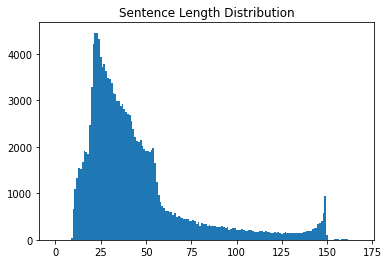

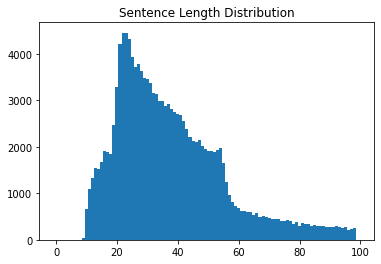

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375224 May  9 07:09 korean_spm.model
-rw-r--r-- 1 root root 144684 May  9 07:09 korean_spm.vocab
[1533, 9, 406, 15, 1388, 9, 138, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_____________________________

KeyboardInterrupt: 

In [13]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import konlpy

%matplotlib inline

path_to_file = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_train.txt'

with open(path_to_file, "r") as f:
    train = f.read().splitlines()

print("Data Size:", len(train))

print("Example:")
for sen in train[0:100][::20]: print(">>", sen)

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = sorted(set(train))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

max_len = 100
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

# 여기서 전체 학습 데이터를 사용하도록 수정
train_path = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_train.txt'
test_path = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/Deep0102/data/ratings_test.txt'

import pandas as pd

# Load datasets
train_df = pd.read_csv(train_path, sep='\t').dropna()
test_df = pd.read_csv(test_path, sep='\t').dropna()

# Extract texts and labels
train_sentences = train_df['document'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()

test_sentences = test_df['document'].astype(str).tolist()
test_labels = test_df['label'].astype(int).tolist()

# Optional: 문장 길이 제한
max_len = 100
train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if len(s) < max_len]
test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if len(s) < max_len]

train_sentences, train_labels = zip(*train_data)
test_sentences, test_labels = zip(*test_data)

# SentencePiece 모델 훈련을 위한 임시 파일 생성 (실제 학습 데이터 사용)
with open(temp_file, 'w') as f:
    for row in train_sentences:   # 실제 훈련에 사용될 데이터로 모델 학습
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

# 토크나이징 함수
def tokenize_with_sp(sp, corpus):
    tensor = [sp.EncodeAsIds(sen) for sen in corpus]
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor

X_train = tokenize_with_sp(s, train_sentences)
X_test = tokenize_with_sp(s, test_sentences)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

vocab_size = len(s)  # SentencePiece vocab size

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 모델 개선: Dropout 추가 및 Embedding 크기 조정
model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),  # 과적합 방지
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 모델 저장 경로
checkpoint_path = './best_sentiment_model.h5'

early_stop = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준
    patience=5,             # 5 epoch 이상 향상 없으면 중단
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

# 배치 크기 줄이기, 학습률 감소 콜백 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

callbacks.append(reduce_lr)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,  # 배치 크기 줄이기
    callbacks=callbacks
)

# 학습 후 가장 좋은 모델 불러오기
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_path)

loss, acc = best_model.evaluate(X_test, y_test)
print("Best Model Test Accuracy: {:.2f}%".format(acc * 100))